In [13]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

In [14]:
# Load dataset
df = pd.read_csv("test.csv")
df = df.dropna(subset=['crimeaditionalinfo', 'category'])

# Encode labels
le = LabelEncoder()
df['category'] = le.fit_transform(df['category'])

# Initialize tokenizer
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Split dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['crimeaditionalinfo'], df['category'], test_size=0.2, stratify=df['category']
)

# Tokenize texts
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=75, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=75, return_tensors="pt")


In [15]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [16]:
# Create datasets
train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())


In [17]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(le.classes_))

from transformers import TrainingArguments, Trainer

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Set up Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\kumar\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# Train the model
trainer.train()


C:\Users\kumar\AppData\Local\Temp\ipykernel_16820\3777488840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss
1,0.809700,0.818023
2,0.741400,0.752096
3,0.673200,0.764342
4,0.590500,0.799969
5,0.486700,0.844886


C:\Users\kumar\AppData\Local\Temp\ipykernel_16820\3777488840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\kumar\AppData\Local\Temp\ipykernel_16820\3777488840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\kumar\AppData\Local\Temp\ipykernel_16820\3777488840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val i

TrainOutput(global_step=7810, training_loss=0.6708822350495909, metrics={'train_runtime': 153798.7622, 'train_samples_per_second': 0.812, 'train_steps_per_second': 0.051, 'total_flos': 4813836835677750.0, 'train_loss': 0.6708822350495909, 'epoch': 5.0})

In [19]:
# Predict on validation set
val_outputs = trainer.predict(val_dataset)
val_preds = torch.tensor(val_outputs.predictions).argmax(dim=1).numpy()

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(val_labels, val_preds, target_names=le.classes_))


C:\Users\kumar\AppData\Local\Temp\ipykernel_16820\3777488840.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.34      0.28      0.31       734
Child Pornography CPChild Sexual Abuse Material CSAM       0.73      0.44      0.55        25
                      Crime Against Women & Children       0.00      0.00      0.00         1
                                Cryptocurrency Crime       0.50      0.52      0.51        33
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00       252
                                     Cyber Terrorism       0.00      0.00      0.00        10
      Hacking  Damage to computercomputer system etc       0.35      0.31      0.33       118
                            Online Cyber Trafficking       0.00      0.00      0.00        12
                              Online Financial Fraud       0.83      0.89      0.86      3778
                            Online Gambling  Betting       

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


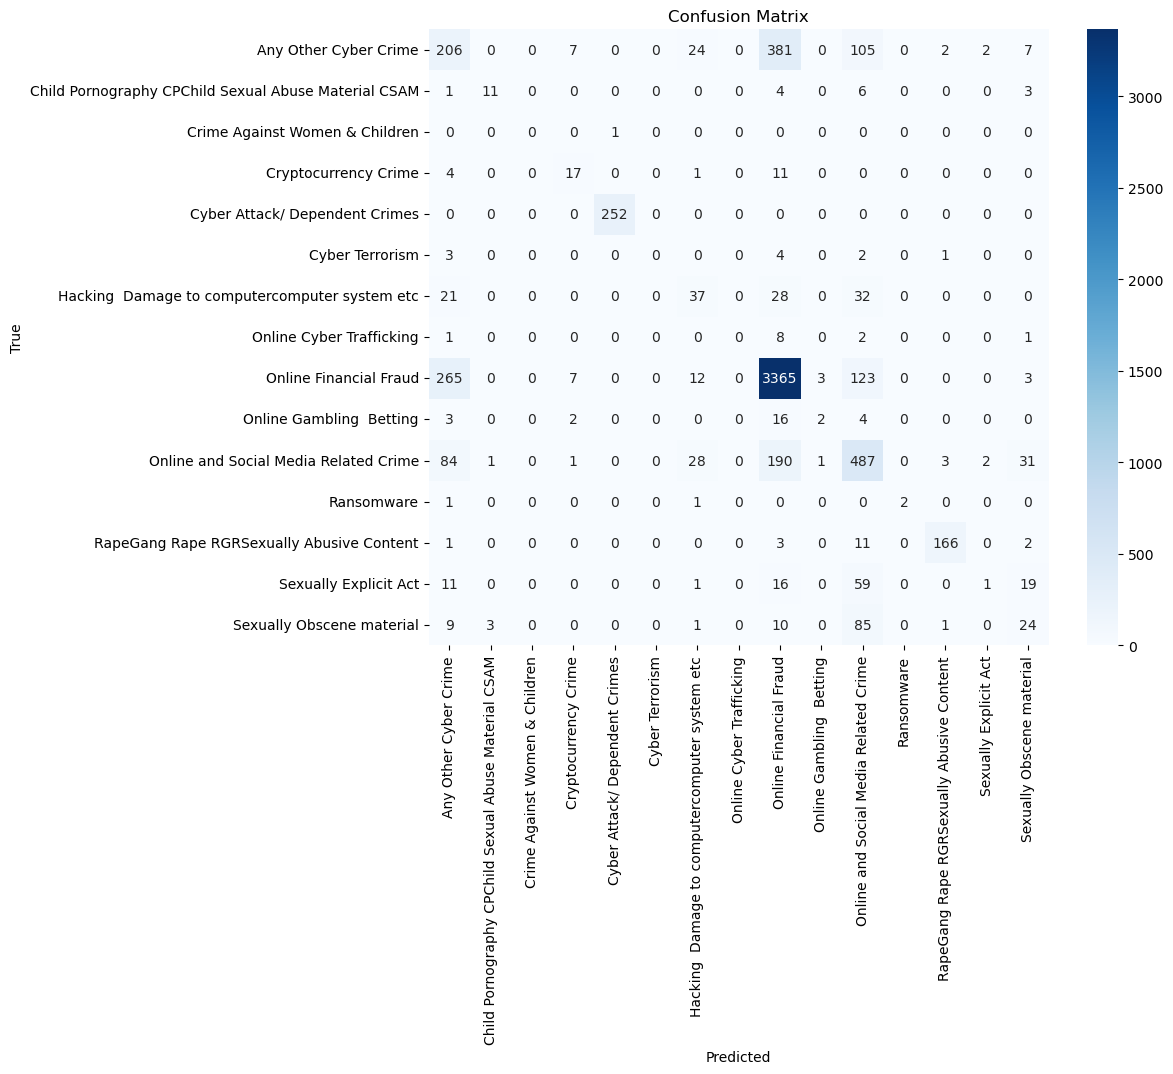

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
